# Preparation

In [1]:
import pandas as pd
import numpy as np
from numpy import expand_dims

#library to read and import file from drive
import os
import zipfile
from shutil import copyfile

from sklearn.model_selection import train_test_split

#images
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn_image as isns

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Paths

In [2]:
path_data = '../Data/DatasetGP5Bicocca'

#### Functions

In [3]:
#function to crop image 
def crop(img, mask=False):
    #gaussian filter
    tmp = cv.GaussianBlur(img,(21,21),0)

    ret1, th1 = cv.threshold(tmp[:,:,2], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret2, th2 = cv.threshold(img[:,:,2], 120, 255, cv.THRESH_BINARY)

    x, y, w, h = cv.boundingRect(th1)
    #return input image with crop and in b&w
    border = 20
    if(mask):
        return th2[y-border:y+h+border, x-border:x+w+border]
    return img[y-border:y+h+border, x-border:x+w+border]

In [14]:
# Function for apply a set of preprocessing functions and saving them divided in train and test sets
def preprocess(source_path, dest_path, functions=[], test_size=0, seed=0):
    #creazione cartelle
    os.mkdir('../Data/Prepared')
    os.mkdir('../Data/Prepared/Train')
    os.mkdir('../Data/Prepared/Train/OK')
    os.mkdir('../Data/Prepared/Train/NOK')
    os.mkdir('../Data/Prepared/Test')
    os.mkdir('../Data/Prepared/Test/OK')
    os.mkdir('../Data/Prepared/Test/NOK')
    
    for folder in os.listdir(source_path):
        list_imgs = os.listdir(source_path + '/' + folder)
        train_imgs, test_imgs = train_test_split(list_imgs, test_size=test_size, random_state=seed) 
        i=0
        for img_name in train_imgs:
            img = cv.imread(source_path + '/' + folder + '/' + img_name)
            for func in functions:
                img = func(img) 
            new_path = dest_path + '/Train/' + folder + '/' + folder + '_' + str(i) + '.bmp'
            cv.imwrite(new_path, img)
            i=i+1
        i=0
        for img_name in test_imgs:
            img = cv.imread(source_path + '/' + folder + '/' + img_name)
            for func in functions:
                img = func(img) 
            new_path = dest_path + '/Test/' + folder + '/' + folder + '_' + str(i) + '.bmp'
            cv.imwrite(new_path, img)
            i=i+1

## Dataset extraction

In [5]:
zipf = zipfile.ZipFile('../Data/Original.zip')
zipf.extractall("../Data")
zipf.close()

## Data exploration and visualization

#### Number of images for each class

In [6]:
list_NOK = os.listdir(path_data + '/NOK')
list_OK = os.listdir(path_data + '/OK')
number_NOK = len(list_NOK)
number_OK = len(list_OK)
print("The number of NO ok images is:", number_NOK)
print("The number of ok images is:", number_OK)

The number of NO ok images is: 19
The number of ok images is: 104


#### Example of OK and NOK images

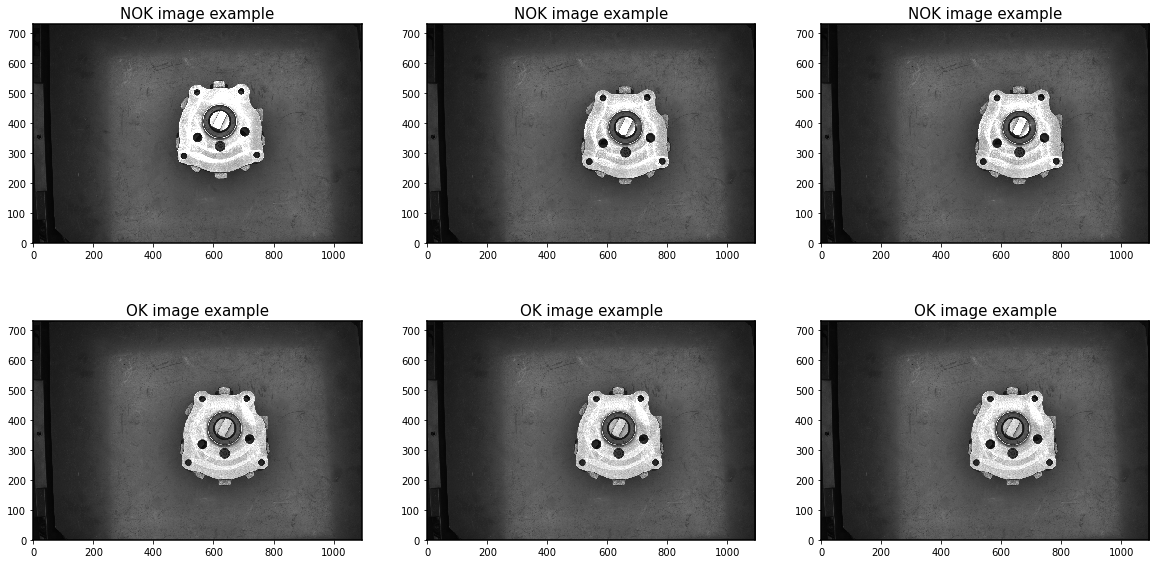

In [7]:
# Plotting the first 3 images for the classes OK and NOK
plt.figure(figsize=(20,10))
i=1
for folder in os.listdir(path_data):
    for img, j in zip(os.listdir(path_data + '/' + folder), range(0, 3)):
        example = cv.imread(path_data + '/' + folder + '/' + img)
        example = cv.resize(example, (None), fx=0.2, fy=0.2)
        plt.subplot(2,3,i)
        plt.title(folder +  ' image example')
        plt.imshow(example)
        i=i+1

Da queste immagini si può notare come la caratteristica principale delle immagini NOK è quella di presentare delle piccole macchie nere sulla superficie del pezzo (dovuto alla mancanza di materiale).
Si osserva che le dimensioni dei difetti sono molto ridotte e questo fatto dovrà essere tenuto in considerazione nella fase di selezione del modello.

### Histogram images comparison

Text(0.5, 1.0, 'Defective piece')

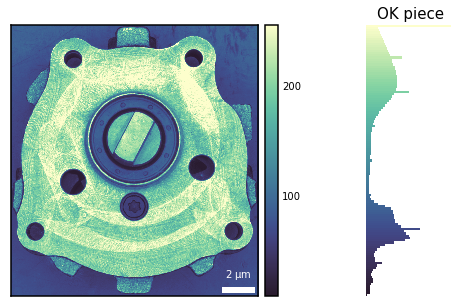

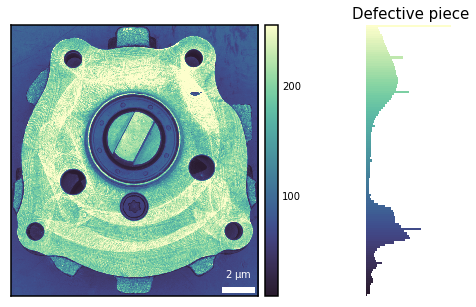

In [8]:
example_ok = cv.imread(path_data + '/OK/OK (1).bmp')
example_nok = cv.imread(path_data + '/NOK/NOK (7).bmp')

example_crop_ok = crop(example_ok)
example_crop_nok = crop(example_nok)

isns.imghist(example_crop_ok[:, :, 0], dx=0.01, units="um")
plt.title('OK piece')

isns.imghist(example_crop_nok[:, :, 0], dx=0.01, units="um")
plt.title('Defective piece')

Non si riscontrano varianze significative negli istogrammi per via della dimensione ridotta dei difetti

## Cleaning

#### Crop production piece from image

Text(0.5, 1.0, 'Threshold mask')

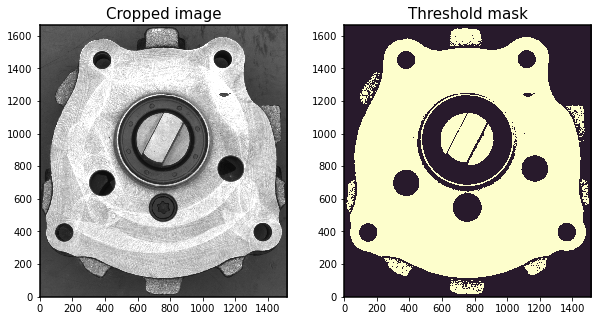

In [9]:
#example of crop function
example_nok = cv.imread(path_data + '/NOK/NOK (7).bmp')

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(crop(example_nok))
plt.title('Cropped image')

plt.subplot(1, 2, 2)
plt.imshow(crop(example_nok, True))
plt.title('Threshold mask')


## Save prepared dataset

In [13]:
preprocess(path_data, dest_path='../Data/Prepared', functions=[crop], test_size=0.2, seed=17)